# Analysis & Visualization of Produced Water Chemistry for Environmental & Agricultural Utilization

## SETUP

In [1]:
# Dependencies
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import sklearn
from wqchartpy import triangle_piper

## DATA CLEANING & FILTERING

## ANALYSIS 

## VISUALIZATION

In [12]:
# ////////// THIS SECTION OF CODE IS TEMPORARY
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
data_path = os.path.join(parent_directory,'data','playground.csv')

df_data = pd.read_csv(data_path,delimiter=',')
df_data.head(2)
# \\\\\\\\\\ THIS SECTION OF CODE IS TEMPORARY

,Sample,Label,Color,Marker,Size,Alpha,pH,Ca,Mg,Na,K,HCO3,CO3,Cl,SO4,TDS
0,sample1,C1,red,o,30,0.6,7.8,32,6,28,2.8,73,0,43,48,233
1,sample2,C2,green,o,30,0.6,7.6,46,11,17,0.7,201,0,14,9,299


In [9]:
# Because wqchartpy automatically generates the chart image files within the main directory as part of the library code, the following function is needed to push 
#       them to our images folder as they're generated to keep our file structure organized. A function was created since this will be used repeatedly.

def move_wqchartpy_image_file_to_images_folder(image_file_name, image_folder_name):
    current_directory = os.getcwd()
    parent_directory = os.path.dirname(current_directory)
    current_file_path = os.path.join(parent_directory, 'notebooks', image_file_name)
    image_folder_path = os.path.join(parent_directory, image_folder_name)
    new_file_path = os.path.join(image_folder_path, image_file_name)

    # Check if the images folder exists; if not, it gets created
    if not os.path.exists(image_folder_path):
        os.makedirs(image_folder_path)

    # Check if a file with the same name already exists in the destination folder; if so ask user what to do: override with or without deleting the newly generated image
    if os.path.exists(new_file_path):
        user_input = input(f'A file with the name {image_file_name} already exists in {image_folder_name}. Do you want to override it? (y/n): ').lower()
        if user_input != 'y':
            user_input = input(f'Do you want to delete the newly generated image file? (y/n): ').lower()
            if user_input == 'y':
                os.remove(current_file_path)
                print('File deleted.')
            else:
                print(f'File not deleted. It is located in {current_directory}.')
            print(f'File not moved to images folder. It is located in {current_directory}.')
            return

    # Move the file to the lower folder
    new_file_path = os.path.join(image_folder_path, image_file_name)
    os.rename(current_file_path, new_file_path)

    print(f"File '{image_file_name}' moved to '{image_folder_name}' folder.")

Trilinear Piper plot created. Saving it to /Users/brittanysmacbookair/GitHub Repository Clones/Project1/notebooks 

File 'TestPiper1.png' moved to 'images' folder.


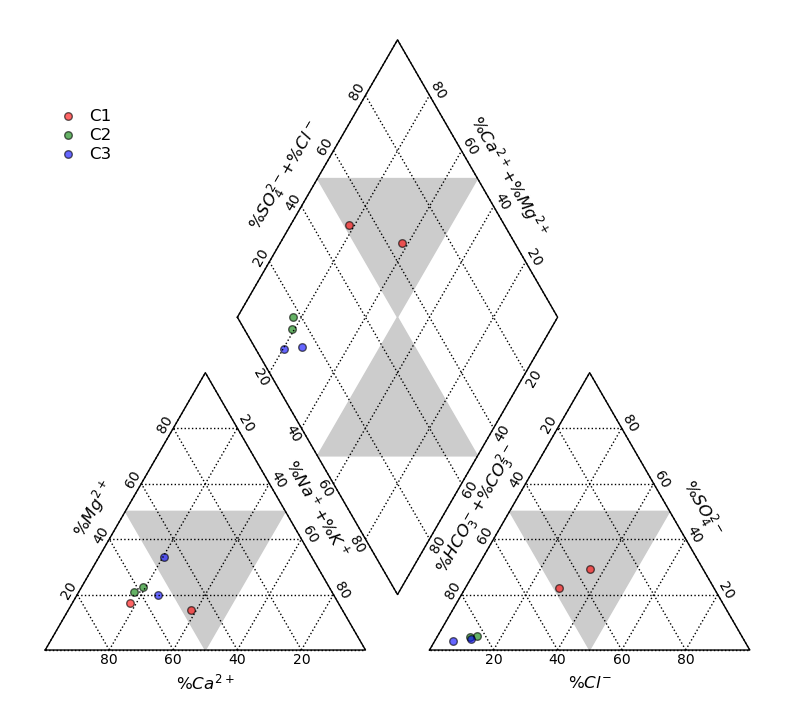

In [11]:
image_name = 'TestPiper1'
triangle_piper.plot(df_data,unit='mg/L',figname=image_name,figformat='png')

image_file_name = f'{image_name}.png'
image_folder_name = 'images'
move_wqchartpy_image_file_to_images_folder(image_file_name, image_folder_name)